In [35]:
import os, warnings
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from keras.utils import np_utils
import keras_tuner as kt

# Project 2 - Veggie Classification

For this assignment you'll need to classify some images of vegetables. 

## Parts

Please do two separate classifications:
<ol>
<li> First, create a model from scratch. 
<li> Use transfer learning to use a pretrained model of your choice, adapted to this data. 
</ol>

There won't be an explicit evaluation of accuracy, but you should take some steps to make each model as accurate as you reasonably can, any tuning option is fair game. Along with that, please structure it into a notebook that is well structured and clear that explains what you did and found. Think about:
<ul>
<li> Sections and headings. 
<li> A description of the approach taken (e.g. what did you do to determine size, tune, evaluate, etc...)
<li> Visualization of some important things such as a confusion matrix and maybe some images. 
<li> Results, mainly focused on the scoring of the test data. 
</ul>

The descriptions and explainations should highlight the choices you made and why you made them. Figure up to about a page or so worth of text total, explain what happened but don't write an essay. 

## Deliverables

Please sumbmit a link to your github, where everyhting is fully run with all the outputs showing on the page. As well, in the notebook please add some kind of switch controlled by a variable that will control if the notebook runs to train the model or to load the model in from weights - so I can download it and click run all, it will load the saved weights, and predict.

### Dataset

The code in the start of this notebook will download and unzip the dataset, and there is also a simple example of creating datasets. You can change the dataset bit to use a different approach if you'd like. The data is already split into train, validation, and test sets. Please treat the separate test set as the final test set, and don't use it for any training or validation. Each folder name is its own label.

### Evaluation

Marking will be based on the following:
<ul>
<li> Models are cretaed, tuned, and effective at classifying the data: 40%
<li> Descriptions and explanations of the approach taken: 20%
<li> Code is well structured and clear: 20%
</ul>

Overall the marking is pretty simple and direct, walk through the process of predicting the veggies, explain what you did, and show the results. If you do that, it'll get a good mark.

### Tips

Some hints that may be helpful to keep in mind:
<ul>
<li> The data is pretty large, so you'll want to use datasets rather than load everything into memory. The Keras docs have a few examples of different ways to load image data, our examples showed image generators and the image from directory datasets.  
<li> Be careful of batch size, you may hit the colab limits. 
<li> You'll want to use checkpoints so you can let it train and pick up where you left off.
<li> When developing, using a smaller dataset sample is a good idea. These weights could also be saved and loaded to jump start training on the full data. 
<li>

### Download and Unzip Data

In [36]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))
import wget
import zipfile
zip_name = "train.zip"

url = "https://jrssbcrsefilesnait.blob.core.windows.net/3950data1/vegetable_image_dataset.zip"

if not os.path.exists(zip_name):
    wget.download(url, zip_name, bar=bar_custom)

with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall()

KeyboardInterrupt: 

In [37]:
# Generate Datasets - you can change this if desired
# ENSURE FILE PATHS MATCH CORRECTLY
IMAGE_SIZE=(224,224)
train_dir='Vegetable Images/train'
val_dir='Vegetable Images/validation'
batch_size = 16

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    val_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Data Preparation

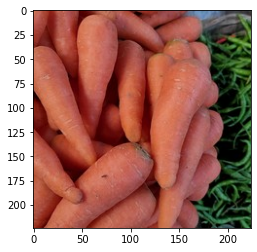

In [38]:
plt.imshow(train_ds.as_numpy_iterator().next()[0][4].astype("int"))

In [39]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.grid(True)
  plt.show()

In [40]:
BASE_EPOCHS = 20
BATCH_SIZE = 10000
BASE_PATIENCE = 5
MIN_DELTA = .02
MONITOR = "val_accuracy"
MODE = "max"

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  BASE_EPOCHS = 75
  BATCH_SIZE = 10000
  BASE_PATIENCE = 10

acc = keras.metrics.CategoricalAccuracy(name="accuracy")
pre = keras.metrics.Precision(name="precision")
rec = keras.metrics.Recall(name="recall")
metric_list = [acc, pre, rec]

callback = tf.keras.callbacks.EarlyStopping(monitor=MONITOR, patience=BASE_PATIENCE, restore_best_weights=True, min_delta=MIN_DELTA, mode=MODE)

## Custom Model Training

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), padding="same",  input_shape=(224, 224, 3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), padding="same"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D(),
    # tf.keras.layers.Conv2D(256, (3,3), padding="same"),
    # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.MaxPooling2D(),
    # tf.keras.layers.Conv2D(512, (3,3), padding="same"),
    # tf.keras.layers.LeakyReLU(),
    # tf.keras.layers.MaxPooling2D(),
    # tf.keras.layers.Dropout(.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_regularizer="l2"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(128, kernel_regularizer="l2"),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dense(15, activation="softmax")
])
model.compile(
  #optimizer=tf.optimizers.Adam(learning_rate=0.001),
  optimizer="rmsprop",
  #loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  loss="categorical_crossentropy",
  metrics=['accuracy']
  )
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 112, 112, 128)     0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [42]:
# Train
log_m1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=BASE_EPOCHS,
    callbacks=[callback]
)
plot_loss(log_m1)
plot_acc(log_m1)

Epoch 1/20
 45/938 [>.............................] - ETA: 42:18 - loss: 6524.1953 - accuracy: 0.1778

KeyboardInterrupt: 

## Transfer Learning Model

## Test Best Models and Illustrate Results

In [ ]:
test_dir='Vegetable Images/test'
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode='categorical',
    image_size = IMAGE_SIZE,
    batch_size = batch_size,
)

Found 3000 files belonging to 15 classes.
